In [1]:
import pandas
import numpy as np
import time
from datetime import date
today = date.today()
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_colwidth', None)

In [2]:
!if [ \! -f Gnt_comprehensive_metaT.zip ];then zip -r Gnt_comprehensive_metaT.zip ../results ../SraRunTable-10.txt ../target_SRAs.txt; fi

In [3]:
!cat ../meta_T.nf

nextflow.enable.dsl=2

process dump_and_bowtie {
  conda 'sra-tools=2.10.8 bowtie2=2.4.2 samtools=1.10 pv=1.6.6' 
  storeDir "results"
  errorStrategy "retry"
  maxRetries 50
  maxForks 1
  scratch 'ram-disk'
  cpus 6
  input: 
   tuple val(SRA), val(index_name), path(index_files)
  output:
   path "${SRA}-${index_name}.aligned_reads.wrg.bam"
  tag "${SRA}"
shell:
'''
    ##If you don't set this, by default it will cache huge files in your home directory. Gross!
    mkdir -p sra_cache
    vdb-config -s "/repository/user/main/public/root=$(pwd)/sra_cache"

    ## Pull down the reads
    fasterq-dump --threads !{task.cpus} --print-read-nr --split-files --temp ./ !{SRA}

    ## Delete source fastqs if too small.  Some sort of problem occured?
    find . -name '*.fastq' -type 'f' -size -160k -delete
        
    ## Concatenate the fastqs via a named pipe
    ## Use pipe viewer(pv) for some simple progress statistics.
    du -hs ./*.fastq
    FILESIZE=`du -scb ./*.fastq | grep total | cut -

In [4]:
##../results/ is filled with .bam files from the Nextflow comprehensive metatranscriptomics pipeline ../meta_T.nf
!find '../results/' -iname '*.bam' | wc -l

2609


In [5]:
!find '../results/' -iname '*.bam' | xargs -n 1 samtools view | gzip > all.sam.gz
!du -hs all.sam.gz


##This direct pandas approach doesn't work as the sam files don't have consistent # of columns throughout all alignments
##See cell below for the miller delimited-key-value-pairs (DKVP) approach 
#all_reads_df = pandas.read_csv('all.sam.gz', compression='gzip', header=0, sep='\t')

512	all.sam.gz


In [6]:
##Count how many reads mapped for a given SRR_ID
##Inspired by this: https://github.com/samtools/samtools/issues/665
##Cut is for removing the qualty scores column, which can have an "=" and screw up miller
##By filtering from AS -100, that means pass all reads but do the miller DKVP reformatting 
!zcat all.sam.gz | cut -f 1-10,12-50 | sed -r 's/\t(..):.:([^\t]*)/\t\1=\2/g' | mlr --fs tab filter '$AS >= -100' > sam.millered.txt
#!zcat all.sam.gz | cut -f 1-10,12-50 | sed -r 's/\t(..):.:([^\t]*)/\t\1=\2/g' | mlr --fs tab filter '$AS >= 100' > sam.millered.txt

###Old way, which used bash scripts:
#!cat sam.millered.txt | cut -f 1 | cut -d "." -f 1 | cut -f 2 -d "=" | sort | uniq -c | sort -nr | tee results.txt

In [7]:
##Convert the millered sam file to a dataframe
import re
handle = open("sam.millered.txt","r")
theDicts = []
for l in handle.readlines():
    keys = [w.split('=')[0] for w in re.split("\t",l.strip())]
    values = [w.split('=')[1] for w in re.split("\t",l.strip())]
    theDict = dict(zip(keys, values))
    theDicts.append(theDict)
all_reads = pandas.DataFrame(theDicts)
all_reads = all_reads.rename(columns={"1":"QNAME",
                          "2":"FLAG",
                          "3":"RNAME",
                          "4":"POS",
                          "5":"MAPQ",
                          "6":"CIGAR",
                          "7":"RNEXT",
                          "8":"PNEXT",
                          "9":"TLEN",
                          "10":"SEQ",})
new_cols = [ {"SRR_id":i.split(".")[0],
              "read_id":i.split(".")[1].split("/")[0],
              "read_dir":i.split(".")[1].split("/")[1]} for i in all_reads["QNAME"].values ]
df2 = pandas.DataFrame(new_cols)
all_reads = all_reads.join(df2)

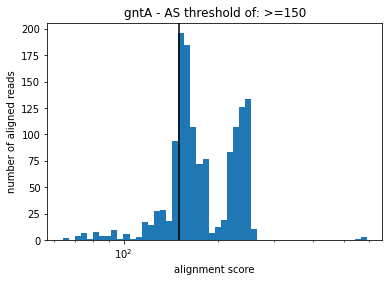

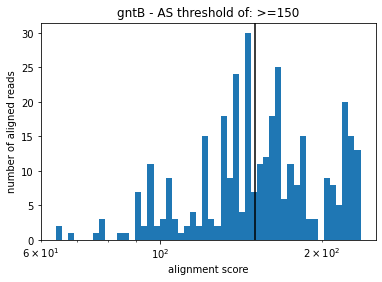

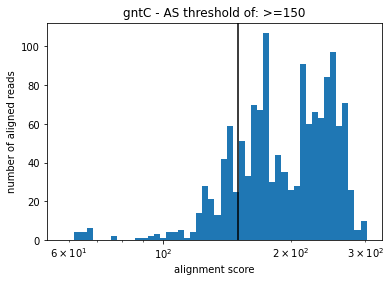

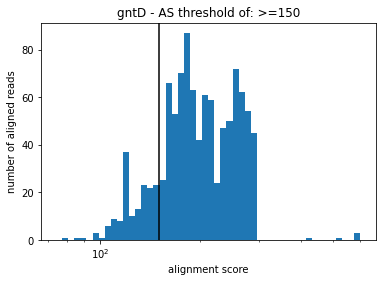

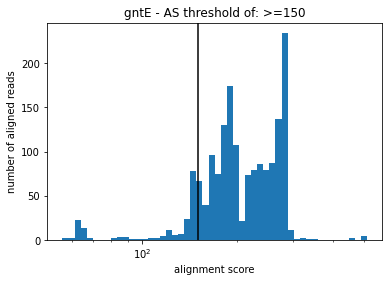

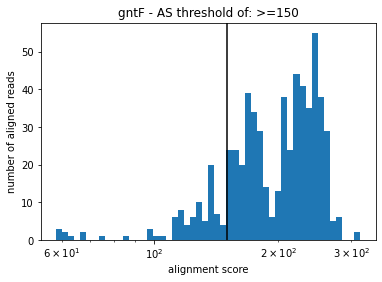

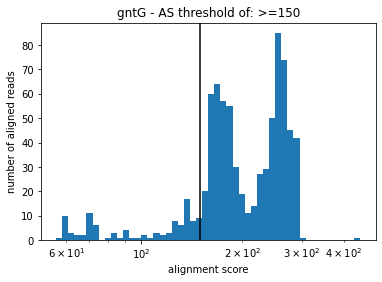

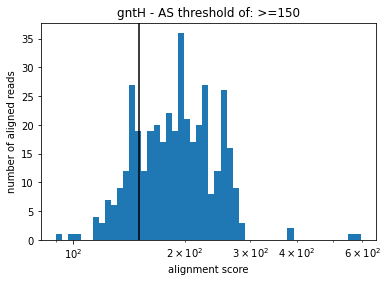

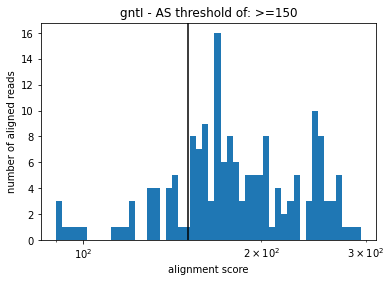

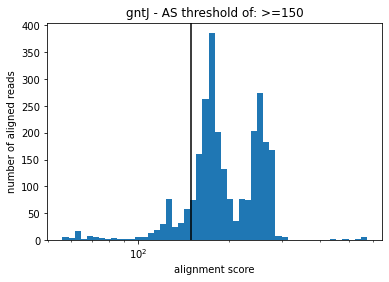

In [8]:
##Plot the distribution of alignment scores of all genes
thresh = 150

#fig, axs = plt.subplots(5, 5)
#col=0
#row=0


import numpy
import matplotlib
import matplotlib.pyplot
thresholds = dict()
targets = sorted(list(set(all_reads["RNAME"].values)))
for target in targets:
    x = all_reads[all_reads["RNAME"] == target]["AS"].astype(int).values
    hist, bins = numpy.histogram(x, bins=50)
    logbins = numpy.logspace(numpy.log10(bins[0]),numpy.log10(bins[-1]),len(bins))
    matplotlib.pyplot.hist(x,bins=logbins)
    #thresholds[target] = thresh
    matplotlib.pyplot.xscale('log')
    matplotlib.pyplot.xlabel('alignment score')
    matplotlib.pyplot.ylabel('number of aligned reads')
    matplotlib.pyplot.axvline(x=thresh,color='black')
    matplotlib.pyplot.title(target+' - '+'AS threshold of: >='+str(thresh))
    matplotlib.pyplot.show()

In [9]:
print("thresh is:",thresh)
thresholded_reads = all_reads[all_reads["AS"].astype(int) >= thresh] ##Alignment score filtering handled by miller 'filter' tool above

thresh is: 150


In [10]:
reads_per_sra = thresholded_reads["SRR_id"].value_counts()
all_sras = reads_per_sra.index
genes_by_sra = []
for s in all_sras:
    matched_genes = sorted(list(set(thresholded_reads[thresholded_reads["SRR_id"] == s]["RNAME"].values)))
    genes_by_sra.append({"SRR_id":s,"matched_genes":",".join(matched_genes)})
genes_df = pandas.DataFrame(genes_by_sra)
genes_df = genes_df.set_index("SRR_id")

results_df = pandas.DataFrame(reads_per_sra)
results_df = results_df.rename(columns={"SRR_id":"Matched Reads (AS >= "+str(thresh)+")"})

##Old way to load, using bash script files, below:

##Load results into dataframe
#results_df = pandas.read_csv('results.txt',delimiter="\s+",header=None,names=["Matched Reads (AS >= 100)","SRR_ID"])
#results_df = results_df.sort_values("SRR_ID",ascending=False).reset_index()

##Redesigned in pandas format

##Load matched gene results into dataframe
#genes_df = pandas.read_csv('genes.txt',delimiter="\s+",header=None,names=["SRR_ID","matched_genes"])

In [11]:
results_df

,Matched Reads (AS >= 150)
SRR5249014,1912
SRR5249015,1887
SRR1601415,1274
SRR1601417,1188
SRR1601416,938
SRR5834679,160
SRR6435700,148
SRR5194976,111
SRR6435855,100
SRR6435865,94


In [12]:
genes_df

,matched_genes
SRR_id,
SRR5249014,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR5249015,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR1601415,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR1601417,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR1601416,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR5834679,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR6435700,"gntA,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR5194976,"gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR6435855,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntJ"


In [13]:
##Merge the counted reads & matched genes
data_genes_df = results_df.join(genes_df)
data_genes_df
##Old way to do it:
#data_genes_df = results_df.merge(genes_df).sort_values('Matched Reads (AS >= 100)',ascending=False).reset_index().drop(["level_0","index"],axis=1)

,Matched Reads (AS >= 150),matched_genes
SRR5249014,1912,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR5249015,1887,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR1601415,1274,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR1601417,1188,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR1601416,938,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR5834679,160,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR6435700,148,"gntA,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR5194976,111,"gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"
SRR6435855,100,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntJ"
SRR6435865,94,"gntA,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ"


In [14]:
import pysradb
from pysradb.sraweb import SRAweb
db = SRAweb()

/home/tfallon/miniconda3/lib/python3.7/site-packages/pysradb/utils.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [15]:
import pickle
import os
import os.path
##Fetch the SRA metadata and load it into a dataframe
##It can be a bit finicky, so we can make a local pickle cache:
pkl_file = 'sra_df.pkl'
if os.path.isfile(pkl_file):
    with open(pkl_file, 'rb') as f:
        sra_df = pickle.load(f)
        assert sorted(list(sra_df.index)) == sorted(list(data_genes_df.index))
else:
    sra_df = db.sra_metadata(list(data_genes_df.index),detailed=True)
    sra_df = sra_df.set_index("run_accession")
    with open(pkl_file, 'wb') as f:
        pickle.dump(sra_df, f)

In [16]:
##Merge the SRA metadata, with the SRA IDs and matched reads dataframe

data_w_meta = data_genes_df.join(sra_df)

###Old way to do it
##data_w_meta = pandas.merge(data_genes_df,sra_df,left_on="SRR_ID",right_on="run_accession")

In [17]:
## Add special metadata from out of band (e.g. emails)

#### SRR5249015 & SRR5249014, from 2020-09-06 email from Robert.Mckay@uwindsor.ca
theIndex = "SRR5249015"
theCol = "collection_date"
data_w_meta.loc[theIndex,theCol] = "2013-06-11"

theIndex = "SRR5249014"
theCol = "collection_date"
data_w_meta.loc[theIndex,theCol] = "2013-06-11"
#### 

#### SRR5860223, from 2020-09-22 email from bcampb7@clemson.edu
theIndex = "SRR5860223"
theCol = "collection_date"
data_w_meta.loc[theIndex,theCol] = "2014-03-19"
#### 

In [18]:
##Pull out the especially interesting columns
data_w_meta_subset = data_w_meta[["Matched Reads (AS >= "+str(thresh)+")",\
             'matched_genes',"geo_loc_name",\
             'env_biome','env_feature','lat_lon','collection_date']]

excel_writer = pandas.ExcelWriter(today.strftime("%Y-%m-%d")+'_comprehensive_metaT-subset.xlsx', engine='xlsxwriter')
data_w_meta_subset.to_excel(excel_writer,sheet_name='pandas')
##Customize some of the column widths
worksheet = excel_writer.sheets['pandas']
worksheet.set_column('A:A', 20)
worksheet.set_column('B:B', 20)
worksheet.set_column('C:C', 40)
worksheet.set_column('D:I', 25)
##Actualy save the file
excel_writer.save()
print("number of rows:",len(data_w_meta_subset))
data_w_meta_subset

number of rows: 77


,Matched Reads (AS >= 150),matched_genes,geo_loc_name,env_biome,env_feature,lat_lon,collection_date
SRR5249014,1912,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ","USA: Sandusky Bay, Ohio",N/A,N/A,41.474889 N 82.854137 W,2013-06-11
SRR5249015,1887,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ","USA: Sandusky Bay, Ohio",N/A,N/A,41.474889 N 82.854137 W,2013-06-11
SRR1601415,1274,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ",USA,Lake Erie,Western Basin,41.7394 N 83.3750 W,08-Oct-2013
SRR1601417,1188,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ",USA,Lake Erie,Western Basin,41.6989 N 83.4589 W,08-Oct-2013
SRR1601416,938,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ",USA,Lake Erie,Western Basin,41.6989 N 83.4589 W,08-Oct-2013
SRR5834679,160,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ",USA: Wisconsin,N/A,N/A,43.099 N 89.405 W,2016-07-14
SRR6435700,148,"gntA,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ",USA: Wisconsin,N/A,N/A,43.099 N 89.405 W,2016-07-15
SRR5194976,111,"gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ","USA:Wisconsin,Dane,Madison,Lake Mendota",freshwater biome,freshwater lake,43.082834 N 89.409982 W,2015-08-21
SRR6435855,100,"gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntJ",USA: Wisconsin,N/A,N/A,43.099 N 89.405 W,2016-07-15
SRR6435865,94,"gntA,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ",USA: Wisconsin,N/A,N/A,43.099 N 89.405 W,2016-07-16


In [19]:
##Display the full dataframe
#data_w_meta

In [ ]:
def openpyxl_resize_columns(path):
    import openpyxl
    wb_obj = openpyxl.load_workbook(path)
    ws = wb_obj.active

    for column_cells in ws.columns: 
        unmerged_cells = list(filter(lambda cell_to_check: cell_to_check.coordinate not in ws.merged_cells, column_cells)) 
        length = max(len(str(cell.value)) for cell in unmerged_cells) 
        ws.column_dimensions[unmerged_cells[0].column_letter].width = length * 1.2

    wb_obj.save(path)

In [20]:
data_w_meta.to_excel(today.strftime("%Y-%m-%d")+'_comprehensive_metaT.xlsx')
openpyxl_resize_columns(today.strftime("%Y-%m-%d")+'_comprehensive_metaT.xlsx')

In [30]:
##See https://stackoverflow.com/questions/29463274/simulate-autofit-column-in-xslxwriter

In [ ]:
#data_w_meta[['Matched Reads (AS >= 100)','SRR_ID']]

In [ ]:
##Select only those detections that have metadata, plus other characteristics
##Changing the title for the orthomap plot may be necesarry
selection_series = np.logical_and(data_w_meta['lat_lon'] != 'missing',data_w_meta['collection_date'] != 'missing')
#selection_series = np.logical_and(selection_series,data_w_meta['matched_genes'] == 'gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ,')
#selection_series = data_w_meta['matched_genes'] == 'gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ,'
sub_df = data_w_meta[selection_series]
print("number of rows:",len(sub_df))
sub_df
#sub_df[["Matched Reads (AS >= 100)",\
#             'matched_genes',"SRR_ID","geo_loc_name",\
#             'env_biome','env_feature','lat_lon','collection_date']]

In [ ]:
##Based off https://matplotlib.org/basemap/users/examples.html
##Also https://scientificallysound.org/2016/06/09/matplotlib-how-to-plot-subplots-of-unequal-sizes/
##And https://stackoverflow.com/questions/53611722/is-it-possible-to-create-a-subplot-from-existing-matplotlib-figure-objects

## Note, rather than coordinating figures in Matplot lib via subplot, could coordinate on the final figure SVG files:
## https://stackoverflow.com/questions/22521560/how-to-combine-several-matplotlib-figures-into-one-figure
## And: https://github.com/btel/svg_utils

%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig1 = plt.figure(1)
# large subplot
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
map = Basemap(projection='ortho',lat_0=10,lon_0=-70,resolution='l')

# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='#ffffff',lake_color='#dfffff')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='#dfffff')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

##Deleted from the example
# make up some data on a regular lat/lon grid.
#nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
#lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
#lons = (delta*np.indices((nlats,nlons))[1,:,:])
#wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
#mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
# compute native map projection coordinates of lat/lon grid.
#x, y = map(lons*180./np.pi, lats*180./np.pi)
# contour data over the map.
#cs = map.contour(x,y,wave+mean,15,linewidths=1.5)

##Draw points first, so they are on top.
lat_long = sub_df['lat_lon']
lats = np.asarray([ float(i.split(" ")[0]) if i.split(" ")[1] == "N" else float(i.split(" ")[0])*-1 for i in lat_long ])
lons = np.asarray([ float(i.split(" ")[2])*-1 if i.split(" ")[3] == "W" else float(i.split(" ")[2]) for i in lat_long ]) 
x, y = map(lons,lats)
map_title_string='('+str(len(lats))+' SRA samples; >=1 read(s) with AS >='+str(thresh)+')'
plt.scatter(x,y,20,marker='o',color='red',zorder=3)
plt.title('Global metatranscriptomic detection of GNT BGC\n'+map_title_string)
plt.savefig('orthomap.png')
plt.savefig('orthomap.svg')

plt.show()

In [ ]:
##Based off https://matplotlib.org/basemap/users/examples.html
##Also https://scientificallysound.org/2016/06/09/matplotlib-how-to-plot-subplots-of-unequal-sizes/
##And https://stackoverflow.com/questions/53611722/is-it-possible-to-create-a-subplot-from-existing-matplotlib-figure-objects

## Note, rather than coordinating figures in Matplot lib via subplot, could coordinate on the final figure SVG files:
## https://stackoverflow.com/questions/22521560/how-to-combine-several-matplotlib-figures-into-one-figure
## And: https://github.com/btel/svg_utils

%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig1 = plt.figure(1)
# large subplot
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='#ffffff',lake_color='#dfffff')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='#dfffff')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

##Deleted from the example
# make up some data on a regular lat/lon grid.
#nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
#lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
#lons = (delta*np.indices((nlats,nlons))[1,:,:])
#wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
#mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
# compute native map projection coordinates of lat/lon grid.
#x, y = map(lons*180./np.pi, lats*180./np.pi)
# contour data over the map.
#cs = map.contour(x,y,wave+mean,15,linewidths=1.5)

##Draw points first, so they are on top.
lat_long = sub_df['lat_lon']
lats = np.asarray([ float(i.split(" ")[0]) for i in lat_long ])
lons = np.asarray([ float(i.split(" ")[2])*-1 for i in lat_long ]) ##Since all are W, just multiply by -1
x, y = map(lons,lats)
plt.scatter(x,y,20,marker='o',color='red',zorder=3)
plt.title('Global metatranscriptomic detection of GNT BGC\n'+map_title_string)
plt.savefig('map.png')
plt.savefig('map.svg')

plt.show()

In [ ]:
sub_df[["Matched Reads (AS >= "+str(thresh)+")",'matched_genes',"geo_loc_name",'env_biome','env_feature','lat_lon','collection_date']]

In [ ]:
## Trying to draw timeline & map together, using matplotlib subplots
## https://stackoverflow.com/questions/17543359/drawing-lines-between-two-plots-in-matplotlib
%matplotlib inline

fig2 = plt.figure(1)

grid_nrows = 4 ##Number of columns in overall figure
grid_ncols = 7 ##Number of rows in overall figure
gridspec.GridSpec(grid_nrows,grid_ncols) ##width, height
plt.subplot2grid((grid_nrows,grid_ncols), (0,0), colspan=4, rowspan=4) ##subplot2grid((nrows, ncols), (row, col), rowspan, colspan)

#######
## Map goes here
#######
plt.title('Global metatranscriptomic detection of GNT BGC\n'+map_title_string)

# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
map = Basemap(projection='ortho',lat_0=10,lon_0=-70,resolution='l')

# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='#ffffff',lake_color='#dfffff')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='#dfffff')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

##Draw points first, so they are on top.
lat_long = data_w_meta['lat_lon'][data_w_meta['lat_lon'] != 'missing']
lats = np.asarray([ float(i.split(" ")[0]) for i in lat_long ])
lons = np.asarray([ float(i.split(" ")[2])*-1 for i in lat_long ]) ##Since all are W, just multiply by -1
x, y = map(lons,lats)
plt.scatter(x,y,20,marker='o',color='red',zorder=3)

##Timeline 1
top_row = 0 ##Starting at 0
left_col = 4 ##Starting at 0
plt.subplot2grid((grid_nrows, grid_ncols), (top_row, left_col),colspan=3,rowspan=2)
dist_tdis = np.random.standard_t(df=29, size=1000)
plt.hist(dist_tdis, bins=30, color='b')

##Timeline 2
top_row = 2 ##Starting at 0
left_col = 4 ##Starting at 0
plt.subplot2grid((grid_nrows, grid_ncols), (top_row, left_col),colspan=3,rowspan=2)
dist_tdis = np.random.standard_t(df=29, size=1000)
plt.hist(dist_tdis, bins=30, color='r')


## Draw line between figures
line = matplotlib.lines.Line2D((0,0),(5000,5000))

fig2.lines.append(line)

plt.tight_layout()
plt.show()

In [ ]:
## trying to make a timeline
##https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/timeline.html
lat_long = data_w_meta['collection_date'][data_w_meta['collection_date'] != 'missing']

In [ ]:
all_ten_match = data_w_meta[data_w_meta['matched_genes'] == 'gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ']
pandas.to_datetime(all_ten_match["collection_date"])
##all_ten_match.replace(pandas.to_datetime(all_ten_match["collection_date"]))

In [ ]:
grouped = all_ten_match.groupby(["collection_date","lat_lon"])
for k in grouped.indices:
    print(k)

In [ ]:
lol = list(zip(list(all_ten_match.index),list(all_ten_match["library_layout"])))
for i in lol:
    print(",".join(i))


In [ ]:
print("New analysis: assemble all SRA samples with all 8 genes")
sra_ids = list(data_w_meta[data_w_meta['matched_genes'] == 'gntA,gntB,gntC,gntD,gntE,gntF,gntG,gntH,gntI,gntJ'].index)
sra_ids = ";".join(sra_ids)
sra_ids

In [ ]:
!cat /home/tfallon/Scripts/nextflow/sra-tools/sra-tools.nf

In [ ]:
!cat /home/tfallon/Scripts/nextflow/spades/spades.nf

In [ ]:
!cat /home/tfallon/Scripts/nextflow/prokka/prokka.nf

In [ ]:
%%writefile gnt_peps.faa
>GntA GntA
MRKNPFESNLALEHSCYAKFDGTEFKILESGTKISEKVTEVHAEFREKILHRTPPFTCMGATSVFNQNNYRFSMYSDMCTKETTLALARNLFTFVNEQDSMNSHFTAFIAVFEKPIPEDEHHFEKLVWSQLQMLHDEDSRYHDWDTQFSNDINNHKFSYSFAERSFFIIGMHPGSSRIARQFSYPLLVFNASRQFDHLVETNQFHNFVRIIRERDVALQGSINPNLPAKYDHSRPEEPEVRQYSGRAVEKDWQCPLVVHQKKHKHNQ*
>GntB GntB
MKKNIKKYRFSNSIYHQIKPLLKLDQWHCWLALAEDWIVICFAISISYYLSWYFYPVTILLIGSRQRALATLLHEAAHQVIAKNRTLNFMMGTFFSGYFILQTMSSYRKSHVEKHHRYFGNPDEDPDYKFAISQGLYQQSLDDKTFQMLYIFSPLLLAQVPKYIKSLLIHRFLEDQNYLELVAIGLWWLTIISLSILFNLWQYLILFWLIPYLTVFQIIGWFIELAEHYPLMNNDINLYMSRNRNSHFIEKFLTGMHNENYHLVHHLFPNIPFWNVPKAHEILMQDPNYAQHHSQSGGIVWSNNNAPSILSGLTQVSS
>GntC GntC
MKIQPALLEMWLSEYERVPYNLGESSVDNFTLGELLNLTGDRDALDQLSLMNNDTHGSLRLREAIASLDKSVSPDDILVTAGTTEAILIYFKVRYRSGANVVVPVPTFHVLYETPAFLGYEVRYLQLRAENGFRIDPQELAKLVDDNTEVIVLNTPQNPSGVVCSETEIQSIIEIAEKHNAEILADEHYRFLPHDQDTEILPSLYGLSPKIISLGSTGKCFGCIGLRIGWLIGNPEIIKACHFFKDYTTHTVCVLNDYIAAGVLLHKGKILPRYRQMIQHNIQQFETFIKQQRGLIDWVKPEAGTIAFPFFTDPNINSKIVAKRLVEDHGVLLLPGEAFDRPSHFRIALGVEPSLFQYALEKLAIVIETS
>GntD GntD
MMSIQTLNFTQSELEEIDILLDQVTANYSHAEQPELIDTAAVLAQSLPLRLRQFLHEFKLRETAPACLIKGYPVNDNTIGATPEHWAGHEDAKRTKREQIVFVLCSALLGEIFGWLTQQNAYLIHDVFPIKGYEQDQIGSGSEALLLWHTEDAYHPARGDYLGLMCLRNPCQSITTIGSVDSLKKLTQQQLDILFQPRFIIRPDNAHHADNNYQTETDLDTHLQNAYNQIKHKIISQDNAMALLYGEPSAPYLCVDPAYMEATDEEAKQTLQALIDAIDIEIMDVILQPGDICFVDNFRAVHGRKPFKANYDGNDRWLKRINITRDLRKSKTYRSHPTSRIIDKVPS
>GntE GntE
MLKDSPKSHAFFERAQKVIPFGVNSSHRYWGENTPVIQRGEGAYVYDFDGKSYIDYRLGFGPVILGHAHPFVNQRVIAAIQNGVSFSATQEYEVRVAEHIIKMCPSVDMVRLDNSGSDATRHAIRLARGYTGRDLVLKFEGAYHGDYDYMLWTTPDSLKSRVGKRGEPIGHKTSQGVPDLVSQLLLIAVWNDREGIEKLLKEKGDSIAAIIVEPILANAGGLMPEPGFLQFLRNQCDIYGIVLIFDEVKTGFRIAPGGAGEYFGVQADLSAYAKAMGNGYPISAIGGKRDIMMTIAPGKVVHAGTYTGNVVVTAAADATLEYMQQQDVFGHLNHVGQQLMDGLDEILTRHQINHHIHGLPSLFGLTLSESNPKDWRDVVDTNLELSEQLLIELVNAGIMTDSDPQQTWYVCESHTSEDIAETLNRFETALRKALQK
>GntF GntF
MELKFQENDFQSFEPIPYLNEYFNYPSDYYGGVGFENEQFLQFFAEVAHEYHLNNYLLLDFGCGPTIYSILSLGRNCREIHMSDYLQQNLEQVQLWQQGKPQAFDWYPYLRRALQMETALNQNQPLDSFLDVTDEEIEERARLLREKITSIRKGNARATNPVGEEGKALYEAVVSSFCLEGVAQDLAEWKNLITNLSSTIKPGGLLIFATQIEADSYRIGEGYGTVVNLTEQDIVQTLLNCNFESGSIKTKELKGGPNHTEYDKFLMLTARLAV
>GntG GntG
MSEHFPIDLRSDTVTQPTPSMRQAMAEAIVGDDVYGEDPTVNRLERVAAELLGKESAMFVPSGTMGNLICMLTHCGRGEEVIIGDQAHLFLYERGGSAVLGGIHPYTVSTATDGTLPLSEIRAAVRPDDIHCPRTKLLCVENTQAQRGGLPLSLTYLHSLRDLANELGLRLHCDGARLWNASVAIGVEPSVLSSPFDSLSVCLSKGLAAPIGSLVIGTQSFIDEARRLRKLLGGGMRQVGAIASAGLIALEQMRERLAIDHENAQFLAEGLRECGYEITHPVRTNIIFFRQHEQDTLSLQERLAVWKNSGLLVSDFGDRTIRAVTHYGIERKDINQAISILQQV
>GntH GntH
MSNNKQDINHTELNPMAHSRRGFFTVFIAGISTSVSSIFRKDVAVAENHKAFTAENKSMLSTNNQSFFFPGELLASDEMRITIVGSSSVARKTQSGTSIFLELGNGDSFIFDAGPGVAANYTALGVPYSRMDRIFLSHLHCDHITDLAYIYGQGSMYDRKTPLRIWGPSGKESKFGTNAFVESMKAMCLWHTESLSYHQNGNGYETEVHEFDYAQNPGVAYNEKGVVIKHFPAVHLKDGAVSYRVDWNGLSFVFSGDSQPNTFMVENAQNVDILIHQTIPPAQVWAKEYNMPLEQVIELQNRFDSPPHAVGAIFDQTRPRLGVLTHLYLNENIKVAILDSCQEVYDGPIEIAQDLMVFNISKNEIKQRIAIVPELALQNTVKKYENLPPPKYKPREQLSQWLLDAVIPQEQWK*
>GntI GntI
MKKSIDKIITNLPLWDTQGALKIVPIGDQNFTNQNYRVESNGQVFKVRISEGNQNLIGIAKEEELIVLKAVAKMGIGPEVIAYIPPEGHLVTRFIEGKHFSLQEITQPENIHRIAQILKQVHSIEGIDAAPPPFERIEGLMRNAERKNGIFPDDFEQLLADLQAIKAVLTKVHRKPCLCHNDLAGSNIIEADGSIFLIDWEYAGVANPMFDLANFSMNQNLDREGDKILIESYFGKVSQVELAEINLWKIVAIFIEGVWGVLQAKISQFDRDYQGFANENWQTVRQYTQKESFSEWLSMISLSNH
>GntJ GntJ
MVKSNILSRNVVGYNSTDLSSDHIQAEARDFYARQAGVFAKILNESWSEYTNISHPGFKNDLDLIRQVKELVAPGAKGIDAGCGPLAREVFCFYEDGYDMYGMDVVPENIQTALEYHPSLADRLFLADLTQPLDVPDHSFDFIICNTVIQHINLNSLTNVTFPEWTRILKPGGIIQLMFRSGHGTQIIHDVEFNDQRSFYLYQPEEILEILARYGLSLIPEENGNLGGIIYVTDVRPMENCIFCVRKTD*
>GntT GntT
MYLTLFKQYDFLNRFIRLSVANIVSNLMIPLAGSISLVFLGHLSGVHDLAGSSFAVVLFDFIYYGFYFLRQSTTGVTAQAIGREDQEEMLLIGLRNILIALVLGILLLILQYPFREIAFSMLNDTPEVKASAVAYFNARIIGAPAVFINYVLIGCLLGREESGKVLLISVMGNAVNILLDYLLIIHWGWGATGAGLSMAISQYLMLLVGLIFFCLQIQWQMLKAITGKLLDWSALKSAFVLNGNIFVSTLILISTTDIFSLESNTMGTIIFTQNTLILQIIFLALYFVEGLGLATESLVGYFTGQGAKEKLASLVGLSAQASLVLGLAFALVPALFPQWVFGLFTDHIEIISQIDTYIWWLPLFLTFSSVALALEGYFLGLAEGRTLRNINLTAIILGFMPLSIAAWQFHNNHLLWLAYSMFMCIRMVMLSIQVPRTFESDFGERKILGEME*

In [ ]:
%%writefile gnt_cds.fna
>gntA
ATGCGAAAAAATCCTTTTGAAAGTAATCTAGCACTGGAACACAGTTGTTATGCCAAGTTTGATGGAACAGAATTTAAAATACTTGAGAGTGGTACAAAAATATCAGAGAAGGTAACTGAAGTACACGCTGAATTTCGGGAGAAAATATTGCATCGCACTCCTCCTTTTACTTGTATGGGTGCAACATCCGTATTTAACCAGAATAACTATCGTTTCAGTATGTACAGTGATATGTGTACAAAAGAAACTACCTTAGCATTGGCTCGAAATTTATTCACTTTTGTGAATGAACAAGATAGCATGAATAGTCACTTCACAGCATTTATTGCTGTGTTTGAAAAACCAATACCAGAAGATGAACACCACTTTGAAAAACTGGTGTGGAGTCAACTACAAATGTTACATGATGAAGATAGCCGTTACCATGATTGGGACACCCAATTCAGCAACGATATCAATAATCATAAATTTTCATACAGTTTTGCTGAAAGAAGCTTTTTCATTATTGGAATGCACCCTGGAAGTTCTCGAATTGCTAGGCAATTTTCCTACCCACTTCTAGTATTTAATGCCAGTCGTCAATTTGATCATTTAGTTGAAACTAACCAATTCCATAACTTCGTCAGAATTATTCGGGAGCGTGACGTAGCTCTGCAAGGTAGTATTAATCCTAATCTGCCAGCAAAATATGACCATAGTCGTCCTGAAGAACCTGAAGTCAGACAATATTCTGGACGTGCAGTAGAAAAAGATTGGCAATGTCCTTTAGTTGTACACCAGAAGAAACATAAGCATAATCAATAA
>gntB
ATGAAAAAAAATATTAAAAAATATCGCTTCAGCAATTCTATTTATCATCAAATAAAACCGCTTTTAAAACTTGATCAGTGGCATTGTTGGTTGGCTTTAGCAGAAGACTGGATAGTTATTTGTTTTGCTATTTCCATTAGCTATTATTTGTCTTGGTACTTTTATCCTGTTACCATACTACTCATCGGTTCACGTCAGAGAGCATTAGCCACATTGCTCCATGAAGCAGCCCATCAAGTAATTGCCAAAAATCGCACCTTAAACTTTATGATGGGTACTTTTTTCTCAGGATATTTCATTCTGCAAACAATGTCATCTTATCGGAAATCTCATGTTGAAAAACATCATAGATATTTTGGCAATCCGGACGAAGATCCTGACTACAAGTTTGCAATTTCTCAAGGATTATATCAACAGAGTTTGGATGATAAAACCTTTCAGATGCTTTATATTTTTTCTCCTTTGCTACTTGCTCAAGTACCTAAATATATAAAATCTTTATTAATTCACCGTTTCCTAGAAGATCAAAATTATCTAGAACTGGTTGCTATTGGATTGTGGTGGCTAACAATTATTAGCCTCAGCATTTTATTTAACCTATGGCAATATTTAATTCTCTTCTGGTTAATTCCTTATTTGACGGTTTTTCAAATCATTGGCTGGTTTATTGAATTAGCCGAGCATTACCCTTTAATGAATAATGATATCAATTTGTATATGAGTCGTAACCGCAACAGCCATTTTATTGAGAAATTTCTAACAGGTATGCATAATGAAAACTACCATTTAGTACATCACCTATTTCCCAATATTCCTTTCTGGAATGTGCCTAAAGCACACGAAATATTGATGCAAGATCCAAATTATGCCCAACATCACAGTCAAAGTGGAGGAATAGTCTGGTCAAATAATAATGCACCTAGTATTTTATCAGGACTTACACAAGTGTCATCATAA
>gntC
ATGAAAATTCAACCTGCTTTATTAGAAATGTGGCTGTCTGAATATGAACGAGTACCTTATAACTTAGGAGAAAGCAGTGTTGATAATTTTACCTTGGGAGAATTACTAAATCTTACAGGAGATCGTGATGCTCTTGATCAACTCAGCCTCATGAATAACGACACCCACGGCTCCCTGAGATTACGTGAAGCGATCGCCTCATTAGATAAATCAGTATCCCCAGATGATATTTTAGTGACTGCTGGGACAACAGAAGCCATATTAATTTATTTTAAAGTACGTTACCGTTCCGGTGCTAATGTCGTTGTTCCAGTACCAACCTTCCATGTACTTTATGAAACTCCAGCTTTTTTAGGTTACGAGGTACGCTATCTGCAATTACGAGCAGAAAATGGTTTTCGCATTGATCCTCAAGAATTAGCCAAGTTAGTTGATGATAATACTGAAGTAATAGTTTTGAATACTCCACAAAATCCTAGTGGTGTTGTTTGCTCAGAAACAGAAATTCAGTCCATAATTGAGATTGCAGAAAAGCATAATGCAGAAATTTTAGCTGATGAGCATTACCGTTTTTTACCCCATGATCAAGACACAGAAATTCTGCCTTCGTTGTATGGACTTTCACCCAAAATCATCAGTTTAGGTTCTACAGGTAAATGCTTTGGTTGTATTGGGTTACGCATTGGTTGGCTGATTGGCAACCCAGAAATAATTAAAGCTTGTCACTTTTTCAAAGACTACACAACCCACACTGTCTGCGTCCTTAATGATTACATCGCTGCTGGAGTCTTATTACACAAAGGCAAAATTTTACCCCGTTATCGTCAGATGATTCAGCACAATATTCAGCAGTTTGAAACTTTTATCAAACAACAACGGGGATTAATTGACTGGGTTAAACCTGAAGCGGGTACTATCGCTTTTCCGTTTTTTACCGATCCAAATATCAACAGCAAAATAGTAGCCAAACGTCTGGTAGAAGATCATGGAGTGTTGTTGCTACCTGGTGAAGCATTTGATCGCCCCAGTCATTTCCGCATAGCTTTGGGTGTTGAACCAAGCCTTTTTCAGTACGCATTGGAAAAACTTGCTATTGTGATAGAAACTTCATGA
>gntD
ATGATGAGTATTCAAACGTTAAATTTTACTCAATCTGAACTTGAAGAAATAGACATTCTTTTAGATCAAGTTACTGCTAACTATAGCCATGCAGAACAACCGGAATTGATTGACACTGCTGCGGTATTAGCCCAAAGTTTGCCCCTACGCCTGCGTCAATTTTTACATGAGTTCAAATTGCGAGAAACCGCTCCTGCTTGTCTCATCAAGGGTTATCCAGTTAATGATAATACTATTGGCGCTACTCCTGAACATTGGGCAGGTCATGAAGATGCCAAGCGCACTAAACGAGAGCAAATTGTGTTTGTTTTGTGCAGTGCTTTACTGGGAGAAATATTTGGTTGGCTAACACAGCAAAATGCCTATCTGATCCACGATGTTTTTCCAATTAAAGGCTATGAACAGGATCAAATTGGTTCTGGTAGTGAAGCACTACTGCTTTGGCATACTGAAGATGCTTATCATCCTGCTCGTGGTGACTACTTGGGGCTAATGTGTTTGCGTAATCCTTGCCAGAGTATAACCACTATTGGTTCAGTGGATTCATTAAAAAAACTGACTCAGCAGCAATTAGATATCTTGTTTCAACCACGTTTTATTATTCGCCCAGATAATGCCCATCATGCCGATAATAATTATCAAACAGAAACTGATTTAGATACTCATCTTCAGAATGCTTACAATCAAATAAAGCATAAAATTATCTCCCAAGATAATGCTATGGCTTTGCTATATGGAGAACCTAGCGCACCCTATTTGTGTGTTGATCCAGCTTATATGGAAGCAACAGATGAAGAAGCTAAACAGACTTTGCAAGCCTTGATTGATGCTATTGACATTGAAATCATGGATGTAATTTTACAACCCGGTGATATTTGTTTCGTAGATAATTTCCGTGCTGTGCATGGGAGAAAACCATTTAAAGCCAATTATGATGGTAATGATCGGTGGTTAAAGCGAATTAATATCACACGCGATCTTCGCAAATCTAAAACATATCGTTCTCATCCTACATCTCGAATTATTGATAAAGTACCTTCATAA
>gntE
ATGTTAAAAGATTCCCCAAAATCCCATGCTTTCTTTGAACGCGCACAAAAAGTTATCCCCTTTGGTGTTAATTCCAGCCACCGCTACTGGGGCGAAAATACACCTGTAATTCAGCGTGGTGAAGGAGCGTATGTTTATGACTTTGACGGAAAAAGCTATATTGATTACCGTCTAGGTTTTGGTCCAGTTATTCTTGGTCATGCTCATCCTTTTGTTAATCAGCGTGTCATTGCAGCAATACAAAATGGTGTAAGTTTTTCTGCAACTCAAGAATATGAAGTCCGGGTAGCTGAACATATCATCAAGATGTGTCCTTCTGTTGACATGGTACGTCTGGATAATAGTGGTTCTGATGCTACCCGCCATGCAATTCGTCTGGCCAGAGGTTACACTGGACGAGATCTAGTGTTGAAATTTGAAGGTGCTTATCACGGTGATTACGATTATATGCTTTGGACAACACCAGATAGTCTTAAAAGCCGTGTGGGAAAACGAGGCGAGCCAATTGGACATAAAACCAGTCAAGGTGTACCAGACTTAGTATCTCAATTGTTATTAATAGCAGTTTGGAATGATCGTGAGGGAATAGAAAAACTGTTAAAGGAAAAAGGAGATAGTATTGCTGCCATTATTGTCGAGCCGATTCTTGCTAATGCAGGTGGCTTGATGCCGGAACCTGGATTTTTGCAATTCCTCCGTAATCAATGTGATATTTATGGTATTGTTTTAATTTTCGATGAAGTTAAAACTGGTTTTCGCATCGCACCAGGAGGAGCAGGTGAATATTTTGGCGTACAGGCTGACTTGAGTGCCTATGCTAAAGCTATGGGTAATGGCTATCCGATTTCTGCTATTGGTGGCAAGCGTGACATTATGATGACCATAGCACCAGGTAAGGTGGTACATGCAGGAACTTATACAGGAAATGTAGTAGTTACTGCTGCGGCCGATGCTACCCTTGAATATATGCAACAGCAGGATGTATTTGGGCATCTCAACCACGTTGGACAACAACTGATGGACGGTTTAGATGAAATTCTGACTCGCCATCAAATTAATCATCATATTCATGGTTTACCCTCATTGTTTGGTTTAACTTTGTCAGAATCTAATCCCAAAGATTGGCGTGATGTTGTTGATACCAATTTGGAATTATCTGAACAACTACTGATTGAATTGGTCAATGCTGGTATTATGACTGATTCTGATCCACAACAAACTTGGTATGTGTGTGAGTCTCACACGTCTGAAGATATTGCAGAAACACTAAATAGGTTTGAAACTGCCCTGCGTAAAGCTTTACAGAAATAA
>gntF
ATGGAACTCAAGTTTCAAGAAAATGATTTTCAATCTTTTGAACCAATACCTTATCTGAATGAATACTTTAATTATCCTTCAGATTATTATGGGGGTGTAGGATTTGAGAATGAACAATTCCTACAATTCTTTGCTGAAGTTGCCCATGAATATCATCTCAATAACTATTTGCTATTAGATTTCGGTTGTGGTCCTACTATTTATTCTATCCTCAGCTTAGGACGGAATTGCCGTGAAATACATATGAGTGATTATTTACAACAAAATTTAGAGCAGGTTCAGCTTTGGCAACAAGGAAAGCCCCAAGCTTTCGATTGGTATCCTTATCTGCGTCGCGCCTTGCAAATGGAAACTGCGTTAAATCAGAATCAGCCTTTAGATAGTTTTTTAGATGTTACAGATGAAGAAATAGAAGAACGGGCAAGATTGCTACGGGAAAAAATAACTTCTATCAGAAAAGGCAATGCTCGTGCTACTAATCCTGTGGGAGAAGAAGGAAAGGCATTATATGAAGCGGTGGTTTCTTCTTTCTGTTTAGAAGGTGTAGCACAAGATTTAGCTGAATGGAAAAATTTGATAACTAATTTGTCTTCCACAATTAAACCAGGGGGTTTATTGATATTTGCTACTCAAATTGAAGCTGATAGTTATCGAATTGGAGAGGGTTACGGCACAGTGGTTAATCTCACTGAACAAGATATTGTGCAGACATTATTGAATTGTAATTTCGAGTCAGGTTCAATCAAAACAAAGGAACTTAAAGGCGGTCCGAATCACACTGAGTACGATAAATTCCTGATGTTGACAGCCAGACTTGCTGTGTGA
>gntG
ATGAGTGAGCATTTTCCCATTGATTTACGCAGTGATACAGTTACCCAACCGACACCATCTATGCGTCAAGCTATGGCTGAAGCGATAGTAGGTGACGATGTTTATGGAGAAGATCCAACGGTTAACCGACTGGAACGAGTAGCAGCAGAACTTTTAGGTAAAGAGTCTGCTATGTTTGTACCTAGTGGCACGATGGGTAATCTCATCTGTATGTTAACTCATTGTGGACGTGGAGAAGAAGTGATTATTGGTGATCAAGCTCATCTGTTTTTGTATGAACGTGGTGGCAGTGCTGTATTGGGGGGTATTCATCCTTACACTGTCAGCACAGCAACAGATGGTACTCTTCCTTTATCAGAAATCCGCGCTGCTGTAAGACCTGATGATATTCATTGTCCGAGAACAAAGCTATTATGTGTGGAAAATACACAAGCACAACGAGGCGGTTTGCCTTTATCATTAACTTATTTACACAGCTTGCGTGATTTGGCGAATGAGTTAGGATTAAGATTGCACTGTGATGGAGCGCGTTTGTGGAACGCATCTGTGGCAATTGGGGTTGAACCTAGTGTTTTATCTTCACCTTTTGATTCTTTATCTGTCTGTTTATCAAAGGGTCTGGCTGCACCTATTGGTTCTCTTGTGATCGGAACACAGTCATTTATTGATGAAGCACGGCGGTTACGTAAACTATTGGGTGGTGGTATGCGTCAAGTTGGAGCGATCGCCTCTGCTGGTTTAATTGCCCTAGAACAAATGAGGGAAAGACTGGCTATTGATCATGAAAACGCCCAATTTTTAGCTGAAGGTTTACGTGAATGTGGTTATGAAATCACTCATCCTGTGCGGACTAATATCATATTTTTTCGCCAGCATGAGCAAGATACCTTATCTCTCCAGGAAAGATTAGCTGTTTGGAAAAACTCTGGCTTGTTAGTCTCAGATTTTGGCGATCGCACAATTCGCGCAGTTACCCATTATGGTATTGAACGCAAAGATATTAATCAAGCAATTTCTATTTTACAACAAGTCTAG
>gntH
ATGAGTAACAACAAACAAGACATCAATCACACAGAATTAAATCCCATGGCTCATAGCCGCAGGGGATTTTTTACTGTGTTTATTGCAGGAATTTCTACATCTGTATCTAGTATTTTCAGGAAAGATGTTGCTGTAGCTGAGAACCATAAAGCCTTCACCGCCGAAAACAAATCAATGCTCTCTACCAATAACCAGTCATTTTTTTTTCCAGGTGAATTGTTAGCATCTGACGAAATGCGGATCACTATTGTAGGGTCTTCTTCCGTCGCACGCAAAACCCAATCTGGAACAAGCATCTTTCTCGAACTGGGAAACGGGGACAGTTTCATCTTTGATGCCGGACCTGGTGTAGCTGCCAACTATACAGCGTTGGGTGTACCCTATTCGCGGATGGATAGAATTTTCCTAAGTCACCTTCATTGCGATCACATAACGGATCTTGCCTACATATATGGTCAAGGATCAATGTATGATCGCAAAACACCCCTACGTATCTGGGGACCGAGTGGCAAGGAGTCGAAGTTTGGCACAAATGCTTTCGTCGAGTCAATGAAGGCTATGTGTCTCTGGCACACGGAGAGTCTTTCCTACCACCAGAACGGTAATGGTTATGAAACAGAGGTACATGAATTTGACTATGCTCAAAATCCAGGTGTTGCATACAACGAGAAAGGAGTTGTGATTAAGCACTTTCCCGCAGTTCACCTGAAAGACGGTGCGGTAAGCTACCGTGTGGATTGGAATGGTCTCAGTTTTGTCTTCTCTGGCGACTCGCAACCGAATACATTTATGGTTGAGAACGCACAAAATGTTGATATCTTGATTCACCAAACAATTCCTCCAGCACAGGTTTGGGCAAAAGAATACAATATGCCCCTCGAACAAGTTATAGAACTGCAAAACAGATTTGATTCTCCTCCCCATGCTGTTGGTGCGATTTTCGACCAAACTAGACCACGCTTGGGTGTACTAACTCATTTATATCTAAATGAAAATATAAAAGTTGCCATTCTTGACTCGTGCCAAGAGGTTTACGACGGACCTATTGAAATTGCTCAGGATTTGATGGTTTTCAATATCTCCAAGAATGAAATCAAGCAGCGCATAGCGATCGTCCCTGAATTAGCGTTGCAAAACACCGTCAAGAAGTACGAAAACCTTCCACCACCTAAGTATAAACCAAGGGAGCAGTTGTCCCAGTGGCTTCTGGACGCGGTAATTCCGCAAGAACAATGGAAATAG
>gntI
TTGAAAAAATCCATCGACAAGATCATTACCAACTTACCGCTATGGGATACACAAGGTGCTCTGAAAATTGTGCCAATCGGTGACCAAAACTTCACCAATCAGAATTACCGAGTTGAGAGCAACGGACAGGTATTCAAGGTTCGCATCAGTGAAGGAAATCAAAACCTCATAGGGATTGCCAAAGAAGAAGAACTGATTGTGCTTAAGGCAGTTGCTAAAATGGGTATAGGACCAGAGGTCATTGCATACATACCACCAGAAGGTCATCTGGTAACGCGATTTATAGAGGGTAAGCATTTTTCTCTACAGGAAATCACGCAACCGGAAAACATACATCGAATTGCCCAGATCCTAAAGCAAGTTCATAGTATTGAGGGGATTGACGCTGCACCGCCACCATTTGAGCGAATTGAGGGGCTGATGAGGAACGCTGAACGCAAAAATGGCATATTTCCTGATGATTTTGAACAGTTACTCGCTGACCTACAAGCTATAAAGGCTGTACTGACTAAAGTCCACAGAAAACCATGTCTGTGTCATAACGACTTGGCTGGCTCGAATATCATTGAGGCCGATGGTTCAATTTTCCTGATCGATTGGGAGTACGCAGGTGTAGCAAATCCGATGTTTGACCTAGCTAACTTTTCTATGAATCAGAACCTGGATAGAGAAGGTGATAAAATTCTCATTGAGAGCTACTTTGGGAAAGTTAGTCAGGTGGAGTTAGCAGAAATCAATCTTTGGAAGATAGTTGCTATTTTTATTGAAGGTGTTTGGGGTGTTTTGCAGGCAAAAATTTCTCAATTTGATCGGGACTATCAAGGTTTTGCTAACGAAAATTGGCAAACAGTGCGTCAGTACACGCAAAAGGAAAGCTTTTCAGAATGGCTGTCCATGATATCGTTATCAAACCACTGA
>gntJ
ATGGTAAAATCAAATATTTTAAGTCGTAATGTTGTAGGTTATAATTCCACTGATTTAAGTTCAGATCACATTCAGGCAGAAGCACGTGATTTTTATGCAAGACAAGCAGGAGTATTTGCTAAGATTCTCAACGAATCTTGGTCAGAATACACGAATATTTCTCATCCTGGCTTCAAAAATGATCTCGACCTCATTCGTCAAGTAAAAGAACTTGTTGCTCCTGGTGCAAAAGGAATTGATGCTGGTTGTGGTCCTCTTGCCCGGGAGGTATTCTGCTTTTATGAAGATGGTTATGATATGTATGGTATGGATGTAGTTCCAGAAAATATCCAAACGGCACTGGAGTATCATCCTTCATTGGCTGATCGGCTTTTTTTGGCTGATTTGACGCAGCCACTTGATGTCCCTGATCATTCCTTTGATTTTATTATTTGCAATACAGTAATTCAACACATTAATCTCAATTCTTTAACTAATGTAACCTTTCCAGAGTGGACACGAATACTTAAGCCTGGTGGAATCATTCAGTTAATGTTTAGGTCTGGTCATGGAACTCAAATTATTCATGATGTAGAATTTAACGATCAACGTAGTTTTTATCTGTATCAACCAGAGGAAATTCTAGAAATACTGGCGAGATATGGATTGTCTTTAATTCCAGAAGAGAATGGCAATTTAGGAGGAATTATTTATGTTACTGATGTCAGACCAATGGAAAATTGTATTTTCTGTGTGCGGAAGACAGATTAA
>gntT
ATGTATTTGACACTCTTCAAACAGTATGACTTTCTGAACCGATTTATTCGGTTATCGGTTGCCAATATAGTCTCCAATCTCATGATCCCTCTAGCTGGTTCCATCAGTCTAGTTTTTTTGGGTCATCTCTCAGGAGTCCATGATTTGGCCGGATCATCTTTTGCAGTAGTATTATTTGATTTTATCTACTACGGTTTTTACTTTTTACGACAGAGTACCACTGGCGTTACCGCTCAGGCAATAGGAAGAGAAGACCAGGAGGAGATGTTACTGATAGGACTGCGAAATATCTTAATTGCTTTAGTCTTAGGCATACTGCTTTTGATTTTGCAGTACCCATTTAGGGAGATAGCATTTTCCATGTTAAATGATACTCCAGAGGTTAAAGCTTCGGCGGTTGCCTATTTCAATGCTCGGATTATTGGTGCGCCTGCGGTTTTCATCAATTACGTTCTGATTGGTTGTTTGCTAGGAAGGGAAGAGAGCGGTAAGGTGTTACTAATATCAGTAATGGGAAATGCTGTCAACATATTACTAGACTATTTGCTGATTATCCATTGGGGTTGGGGAGCTACAGGAGCTGGACTCTCTATGGCTATTAGTCAGTATTTAATGTTATTGGTAGGATTAATATTTTTTTGCCTTCAAATCCAGTGGCAAATGTTAAAAGCTATAACTGGAAAACTTTTGGATTGGTCAGCTTTGAAATCTGCCTTTGTCCTGAATGGCAATATATTTGTTAGTACCTTGATCCTGATCTCCACCACTGATATATTCAGTTTAGAGAGCAATACAATGGGGACAATCATCTTTACTCAAAATACCTTGATATTACAAATCATTTTCCTAGCTCTCTATTTTGTTGAAGGATTAGGATTAGCTACAGAGAGTTTAGTAGGCTACTTTACAGGTCAAGGTGCGAAGGAAAAGTTAGCTTCTTTGGTAGGGCTTTCTGCACAAGCTAGTCTTGTTTTGGGACTCGCCTTTGCTCTTGTACCTGCGCTTTTTCCTCAATGGGTATTTGGGTTATTCACCGACCATATTGAAATAATTAGTCAAATTGATACATATATTTGGTGGTTACCACTTTTTTTGACATTTAGTTCAGTAGCACTTGCACTGGAAGGATACTTTCTAGGTTTAGCAGAAGGACGCACTCTTCGCAATATTAACTTAACTGCCATTATTTTAGGATTTATGCCTTTAAGTATAGCCGCTTGGCAGTTTCACAATAACCATTTGTTGTGGCTTGCTTATTCTATGTTTATGTGCATCAGAATGGTGATGCTTAGTATACAAGTACCAAGAACTTTTGAAAGTGATTTTGGAGAGCGAAAAATTTTGGGGGAGATGGAGTAG

In [ ]:
%%writefile targeted_rnaspades.nf
nextflow.enable.dsl=2

include { fasterq_dump } from '/home/tfallon/Scripts/nextflow/sra-tools/sra-tools.nf'
include { rnaspades_PE; rnaspades_S; rnaspades } from '/home/tfallon/Scripts/nextflow/spades/spades.nf'
include { prokka_do; prokka_do_with_pep } from '/home/tfallon/Scripts/nextflow/prokka/prokka.nf'
include { tblastn } from '/home/tfallon/Scripts/nextflow/blast/blast.nf'

process determine_library_layout {
input:
    path fastqs
output:
    tuple(env(LIBRARY_LAYOUT), path(fastqs))
shell:
'''
if [ `ls -1 ./*.fastq.gz | wc -l` -eq 1 ]
then
LIBRARY_LAYOUT="SINGLE"
elif [ `ls -1 ./*.fastq.gz | wc -l` -eq 2 ]
then
LIBRARY_LAYOUT="PAIRED"
elif [ `ls -1 ./*.fastq.gz | wc -l` -eq 3 ]
then
LIBRARY_LAYOUT="TRIPLE"
else
LIBRARY_LAYOUT="UNKNOWN"
fi
'''
}

process fasta_add_prefix {
 conda "seqkit"
 input:
  val prefix
  path fasta
 output:
  path "${prefix}_spades.fa"
 shell:
 '''
 seqkit replace -p "^" -r "!{prefix}_" !{fasta} > !{prefix}_spades.fa
 '''
}

process seqkit_blast_filter {
    conda "seqkit"
    input:
     path(blast_results)
     path(fasta)
    output:
     path "results/${fasta}"
shell:
    '''
    mkdir results
    cat !{blast_results} | awk '$3 > 75' | cut -f 2 | sort | uniq > filter_by.txt
    seqkit grep -f filter_by.txt !{fasta} > results/!{fasta}
    '''
}

workflow rnaAssemble {
take: 
 sraId
main:
 fasterq_dump(sraId)
 determine_library_layout(fasterq_dump.out)

 rnaspades(determine_library_layout.out,"no") //"no" = strand specific or not
 
 fasta_add_prefix(sraId,rnaspades.out.scaffolds)
 emit:
  fasta_add_prefix.out
}

workflow filterByBlast {
take:
 target_pep_tuple
main:
 target = target_pep_tuple.map{it[0]}
 pep = target_pep_tuple.map{it[1]}
    
 tblastn(target,pep)
    
 //out_target_tuple = tblastn.out.combine(target.first())
 //seqkit_tblastn = out_target_tuple.map{it[0]}
 //seqkit_target = out_target_tuple.map{it[1]}
    
 seqkit_blast_filter(tblastn.out.blast_out,tblastn.out.target)
emit:
 seqkit_blast_filter.out   
}

workflow {
target_list = params.targets.split(";").toList() // Groovy split, plus have to convert to "java.util.Collection"
targets = Channel.fromList( target_list )
peps = Channel.fromPath(params.peps)
rnaAssemble(targets)
filterByBlast(rnaAssemble.out.combine(peps))
prokka_tup = filterByBlast.out.combine(peps)
prokka_do_with_pep(prokka_tup.map{it[0]},prokka_tup.map{it[1]})
}

In [ ]:
%%writefile nextflow.config
conda.cacheDir = "/dev/shm/TRF_condaenv"

process {
    maxRetries = 0
    errorStrategy = "finish"
}

//singularity container parameters from below config:
includeConfig '/home/tfallon/Scripts/nextflow/sra-tools/nextflow.config'
includeConfig '/home/tfallon/Scripts/nextflow/prokka/nextflow.config'
includeConfig '/home/tfallon/Scripts/nextflow/spades/nextflow.config'
includeConfig '/home/tfallon/Scripts/nextflow/blast/nextflow.config'

In [ ]:
!if [ ! -d .nextflow ]; then THETMP=`mktemp -d /dev/shm/TRF_XXXXXXXX`; echo $THETMP; ln -s ${THETMP} .nextflow; fi
!nextflow run targeted_rnaspades.nf --targets "$sra_ids" --peps "gnt_peps.faa" --nucl "gnt_cds.fna" -with-trace -resume

In [ ]:
##Produce a shareable html of this notebook
!if [ ! -f metaT_Parse_results.html ];then touch metaT_Parse_results.html; jupyter nbconvert --execute --ExecutePreprocessor.timeout=-1 --to html metaT_Parse_results.ipynb;fi
